<a href="https://colab.research.google.com/github/ShatilKhan/7-Days-of-LangChain/blob/main/Welding_Inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processed part 1568 (CAM1) -> Status: OK
Measurements: [40.0, 40.0, 40.0, 40.0, 220.0, 220.0, 40.0, 40.0, 40.0, 40.0, 88.0, 88.0]
Annotated image saved to: ./749274/OK_749274_1568Count1_CAM1_2.jpg



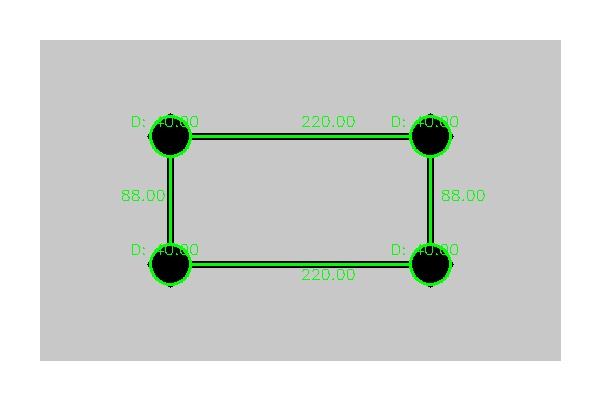

Processed part 1569 (CAM1) -> Status: NOK
Measurements: [40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0]
Annotated image saved to: ./749274/NOK_749274_1569Count1_CAM1_2.jpg



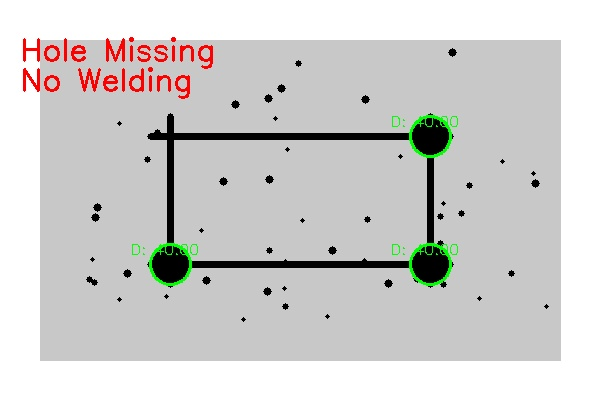

Processed part 1570 (CAM1) -> Status: NOK
Measurements: [40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0]
Annotated image saved to: ./749274/NOK_749274_1570Count2_CAM1.jpg



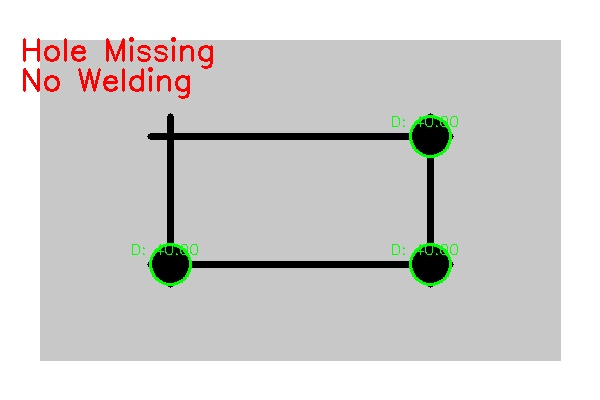

Processed part 1571 (CAM1) -> Status: OK
Measurements: [40.0, 40.0, 40.0, 40.0, 220.0, 220.0, 40.0, 40.0, 40.0, 40.0, 88.0, 88.0]
Annotated image saved to: ./749274/OK_749274_1571Count2_CAM1.jpg



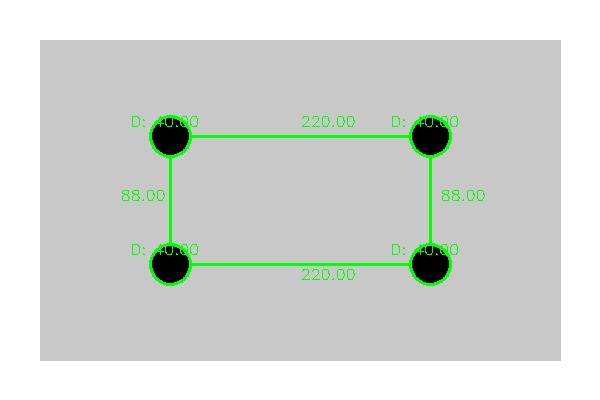

Processed part 1572 (CAM1) -> Status: OK
Measurements: [40.0, 40.0, 40.0, 40.0, 220.0, 220.0, 40.0, 40.0, 40.0, 40.0, 88.0, 88.0]
Annotated image saved to: ./749274/OK_749274_1572Count3_CAM1.jpg



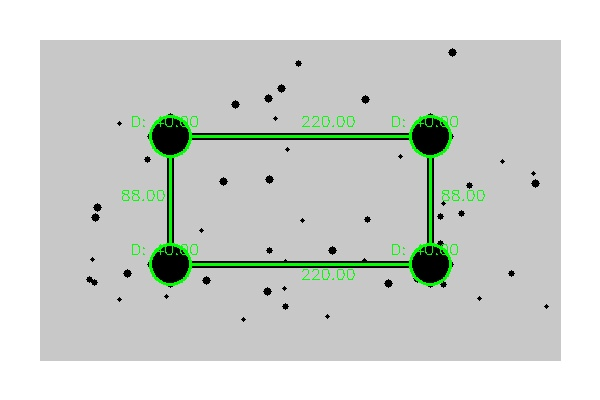

Processed part 1573 (CAM1) -> Status: NOK
Measurements: [40.0, 40.0, 40.0, 40.0, 0.0, 0.0, 40.0, 40.0, 0.0, 0.0, 0.0, 0.0]
Annotated image saved to: ./749274/NOK_749274_1573Count3_CAM1.jpg



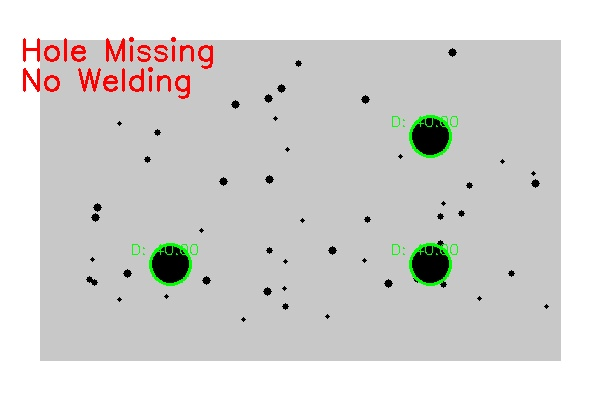

In [6]:
"""
Demo Industrial Inspection Workflow
----------------------------------

This script implements a simplified, self‑contained demonstration of the core
workflow described in the provided job specification and mock‑up
documentation.  It does **not** implement a full PyQt GUI or live camera
integration; instead, it focuses on the most critical pieces of logic so
that the client can see a working proof of concept within a single
Jupyter notebook cell.  The code:

* Creates synthetic test images that mimic a metal part with four holes and
  four weld seams.  An optional set of defects (missing parts, missing welds,
  or spatter) can be enabled to produce NOK (not OK) examples.

* Implements simple computer vision routines for detecting part presence,
  measuring hole diameters, measuring weld seam lengths, and detecting
  weld spatter.

* Annotates the analysed images with measurement overlays and colour
  indicators.  Green boxes/text indicate successful measurements,
  whereas red boxes/text highlight defects (e.g., spatter or missing
  features).

* Saves annotated images and measurement data to a CSV file using the
  non‑overwrite naming rules described in the job specification.  Each
  result row contains: a sequential number, the OK/NOK status, the
  order number, a counter, the date, the time, twelve measurement values,
  and the user name.

Usage example at the bottom shows how to create an Inspector, generate test
images and process them.
"""

import cv2
import numpy as np
import pandas as pd
import os
import datetime
from typing import List, Tuple, Dict
from IPython.display import display, Image

def generate_test_part(
    size: Tuple[int, int] = (600, 400),
    part_missing: bool = False,
    no_welding: bool = False,
    spatter: bool = False,
) -> np.ndarray:
    """Generate a synthetic metal part image for demonstration."""
    width, height = size
    # White background
    img = np.ones((height, width, 3), dtype=np.uint8) * 255
    # Light grey part rectangle
    part_margin = 40
    part_rect = (part_margin, part_margin, width - part_margin * 2, height - part_margin * 2)
    cv2.rectangle(img, (part_rect[0], part_rect[1]),
                  (part_rect[0] + part_rect[2], part_rect[1] + part_rect[3]),
                  (200, 200, 200), -1)
    # Hole centres relative to part
    hole_radius = 20
    hole_offsets = [
        (int(0.25 * part_rect[2]), int(0.3 * part_rect[3])),
        (int(0.75 * part_rect[2]), int(0.3 * part_rect[3])),
        (int(0.25 * part_rect[2]), int(0.7 * part_rect[3])),
        (int(0.75 * part_rect[2]), int(0.7 * part_rect[3])),
    ]
    # Draw holes (black circles)
    for idx, (dx, dy) in enumerate(hole_offsets):
        if part_missing and idx == 0:
            continue
        center = (part_rect[0] + dx, part_rect[1] + dy)
        cv2.circle(img, center, hole_radius, (0, 0, 0), -1)
    # Draw weld seams if required
    weld_thickness = 5
    if not no_welding:
        # Upper horizontal
        p1 = (part_rect[0] + hole_offsets[0][0] - hole_radius,
              part_rect[1] + hole_offsets[0][1])
        p2 = (part_rect[0] + hole_offsets[1][0] + hole_radius,
              part_rect[1] + hole_offsets[1][1])
        cv2.line(img, p1, p2, (0, 0, 0), weld_thickness)
        # Lower horizontal
        p3 = (part_rect[0] + hole_offsets[2][0] - hole_radius,
              part_rect[1] + hole_offsets[2][1])
        p4 = (part_rect[0] + hole_offsets[3][0] + hole_radius,
              part_rect[1] + hole_offsets[3][1])
        cv2.line(img, p3, p4, (0, 0, 0), weld_thickness)
        # Left vertical
        p5 = (part_rect[0] + hole_offsets[0][0],
              part_rect[1] + hole_offsets[0][1] - hole_radius)
        p6 = (part_rect[0] + hole_offsets[2][0],
              part_rect[1] + hole_offsets[2][1] + hole_radius)
        cv2.line(img, p5, p6, (0, 0, 0), weld_thickness)
        # Right vertical
        p7 = (part_rect[0] + hole_offsets[1][0],
              part_rect[1] + hole_offsets[1][1] - hole_radius)
        p8 = (part_rect[0] + hole_offsets[3][0],
              part_rect[1] + hole_offsets[3][1] + hole_radius)
        cv2.line(img, p7, p8, (0, 0, 0), weld_thickness)
    # Add spatter (random black dots)
    if spatter:
        rng = np.random.default_rng(42)
        for _ in range(50):
            x = rng.integers(part_rect[0] + 10, part_rect[0] + part_rect[2] - 10)
            y = rng.integers(part_rect[1] + 10, part_rect[1] + part_rect[3] - 10)
            radius = rng.integers(2, 5)
            cv2.circle(img, (int(x), int(y)), int(radius), (0, 0, 0), -1)
    return img

def detect_part_presence(gray: np.ndarray, mean_threshold: float = 240.0) -> bool:
    """Return True if a part (grey region) is present, otherwise False."""
    mean_val = float(gray.mean())
    return mean_val < mean_threshold

def detect_holes(gray: np.ndarray) -> List[Tuple[Tuple[int,int], float, float]]:
    """Detect circular holes via the Hough Circle Transform."""
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    circles = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT,
        dp=1.0, minDist=50,
        param1=50, param2=20,
        minRadius=10, maxRadius=40
    )
    holes: List[Tuple[Tuple[int,int], float, float]] = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0,:]:
            x,y,r = circle
            diameter = float(r*2)
            holes.append(((int(x),int(y)), diameter, diameter))
    return holes

def detect_spatter(gray: np.ndarray) -> int:
    """Detect number of small dark blobs indicating weld spatter."""
    _, thresh = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    spatter_count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 3 < area < 100:
            spatter_count += 1
    return spatter_count

class Inspector:
    """Encapsulates the inspection workflow: counters, CSV writing and image saving."""
    def __init__(self, user: str, order_number: str, output_dir: str = ".") -> None:
        self.user = user
        self.order_number = order_number
        self.ok_counter = 0
        self.nok_counter = 0
        self.order_dir = os.path.join(output_dir, order_number)
        os.makedirs(self.order_dir, exist_ok=True)
        self.csv_path = os.path.join(self.order_dir, f"{order_number}.csv")
        if not os.path.exists(self.csv_path):
            header = (
                ["Number", "OK/NOK", "Ordernumber", "Counter", "Date", "Time"]
                + [f"Value{i}" for i in range(1,13)]
                + ["User"]
            )
            pd.DataFrame(columns=header).to_csv(self.csv_path, index=False)

    def _next_filename(self, status: str, part_number: str, counter: int, cam_id: int) -> str:
        """Generate a non‑overwriting filename as specified."""
        base = f"{status}_{self.order_number}_{part_number}Count{counter}_CAM{cam_id}.jpg"
        path = os.path.join(self.order_dir, base)
        if not os.path.exists(path):
            return path
        suffix = 1
        while True:
            new_name = f"{os.path.splitext(base)[0]}_{suffix}.jpg"
            new_path = os.path.join(self.order_dir, new_name)
            if not os.path.exists(new_path):
                return new_path
            suffix += 1

    def process_and_save(self, img: np.ndarray, part_number: str, cam_id: int = 1) -> None:
        """Analyse an image, update counters, annotate and save results."""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        part_present = detect_part_presence(gray)
        status = "OK"
        annotated = img.copy()
        measurement_values: List[float] = [0.0] * 12

        if not part_present:
            status = "NOK"
            cv2.putText(annotated, "Part Missing", (20,30), cv2.FONT_HERSHEY_SIMPLEX,
                        1.0, (0,0,255), 2)
        else:
            holes = detect_holes(gray)
            holes = sorted(holes, key=lambda h: h[0][0])
            # Draw holes and record diameters
            for idx, hole in enumerate(holes[:4]):
                centre, width, height = hole
                cv2.circle(annotated, centre, int(width/2), (0,255,0), 2)
                cv2.putText(
                    annotated, f"D: {width:.2f}",
                    (centre[0]-40, centre[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1
                )
                if idx < 2:
                    measurement_values[idx*2] = width
                    measurement_values[idx*2+1] = height
                else:
                    measurement_values[6 + (idx-2)*2] = width
                    measurement_values[6 + (idx-2)*2 + 1] = height
            # Flag hole missing
            if len(holes) < 4:
                status = "NOK"
                cv2.putText(annotated, "Hole Missing", (20,60), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0,0,255), 2)
            # Compute seam lengths from hole positions
            if len(holes) >= 4:
                holes_by_y = sorted(holes, key=lambda h: h[0][1])
                top_row = sorted(holes_by_y[:2], key=lambda h: h[0][0])
                bottom_row = sorted(holes_by_y[2:4], key=lambda h: h[0][0])
                rad_top_left  = top_row[0][1] / 2.0
                rad_top_right = top_row[1][1] / 2.0
                rad_bot_left  = bottom_row[0][1] / 2.0
                rad_bot_right = bottom_row[1][1] / 2.0
                def distance(p1,p2):
                    return float(np.hypot(p2[0]-p1[0], p2[1]-p1[1]))
                len_top    = distance(top_row[0][0], top_row[1][0]) - (rad_top_left + rad_top_right)
                len_bottom = distance(bottom_row[0][0], bottom_row[1][0]) - (rad_bot_left + rad_bot_right)
                len_left   = distance(top_row[0][0], bottom_row[0][0]) - (rad_top_left + rad_bot_left)
                len_right  = distance(top_row[1][0], bottom_row[1][0]) - (rad_top_right + rad_bot_right)
                measurement_values[4]  = len_top
                measurement_values[5]  = len_bottom
                measurement_values[10] = len_left
                measurement_values[11] = len_right
                # Annotate seams
                # top
                p1_top = (int(top_row[0][0][0] + rad_top_left), int(top_row[0][0][1]))
                p2_top = (int(top_row[1][0][0] - rad_top_right), int(top_row[1][0][1]))
                cv2.line(annotated, p1_top, p2_top, (0,255,0), 2)
                mid_top = (int((p1_top[0]+p2_top[0])/2), int(p1_top[1]-10))
                cv2.putText(annotated, f"{len_top:.2f}", mid_top, cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0,255,0), 1)
                # bottom
                p1_bot = (int(bottom_row[0][0][0] + rad_bot_left), int(bottom_row[0][0][1]))
                p2_bot = (int(bottom_row[1][0][0] - rad_bot_right), int(bottom_row[1][0][1]))
                cv2.line(annotated, p1_bot, p2_bot, (0,255,0), 2)
                mid_bot = (int((p1_bot[0]+p2_bot[0])/2), int(p1_bot[1]+15))
                cv2.putText(annotated, f"{len_bottom:.2f}", mid_bot, cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0,255,0), 1)
                # left
                p1_left  = (int(top_row[0][0][0]), int(top_row[0][0][1] + rad_top_left))
                p2_left  = (int(bottom_row[0][0][0]), int(bottom_row[0][0][1] - rad_bot_left))
                cv2.line(annotated, p1_left, p2_left, (0,255,0), 2)
                mid_left = (int(p1_left[0]-50), int((p1_left[1]+p2_left[1])/2))
                cv2.putText(annotated, f"{len_left:.2f}", mid_left, cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0,255,0), 1)
                # right
                p1_right  = (int(top_row[1][0][0]), int(top_row[1][0][1] + rad_top_right))
                p2_right  = (int(bottom_row[1][0][0]), int(bottom_row[1][0][1] - rad_bot_right))
                cv2.line(annotated, p1_right, p2_right, (0,255,0), 2)
                mid_right = (int(p1_right[0]+10), int((p1_right[1]+p2_right[1])/2))
                cv2.putText(annotated, f"{len_right:.2f}", mid_right, cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0,255,0), 1)
            else:
                status = "NOK"
                cv2.putText(annotated, "No Welding", (20,90), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0,0,255), 2)
            # Spatter detection
            spatter_count = detect_spatter(gray)
            if spatter_count > 5:
                status = "NOK"
                cv2.putText(annotated, f"Spatter: {spatter_count}",
                            (20,120), cv2.FONT_HERSHEY_SIMPLEX,
                            1.0, (0,0,255), 2)

        # Update counters and choose filename
        if status == "OK":
            self.ok_counter  += 1
            counter_val = self.ok_counter
        else:
            self.nok_counter += 1
            counter_val = self.nok_counter
        out_path = self._next_filename(status, part_number, counter_val, cam_id)
        cv2.imwrite(out_path, annotated)

        # Compose CSV row
        now = datetime.datetime.now()
        date_str = now.strftime("%Y-%m-%d")
        time_str = now.strftime("%H:%M:%S")
        df_existing = pd.read_csv(self.csv_path)
        next_number = df_existing.shape[0] + 1
        row = {
            "Number": next_number,
            "OK/NOK": status,
            "Ordernumber": self.order_number,
            "Counter": counter_val,
            "Date": date_str,
            "Time": time_str,
        }
        for i, val in enumerate(measurement_values, start=1):
            try:
                row[f"Value{i}"] = round(float(val), 2)
            except Exception:
                row[f"Value{i}"] = 0.0
        row["User"] = self.user
        df_new = pd.concat([df_existing, pd.DataFrame([row])], ignore_index=True)
        df_new.to_csv(self.csv_path, index=False)

        # Print summary
        print(f"Processed part {part_number} (CAM{cam_id}) -> Status: {status}")
        print(f"Measurements: {measurement_values}")
        print(f"Annotated image saved to: {out_path}\n")
        # Display the annotated image
        display(Image(data=cv2.imencode('.jpg', annotated)[1].tobytes()))


# Example usage:
inspector = Inspector(user="Bob", order_number="749274")
ok_img  = generate_test_part()
inspector.process_and_save(ok_img,  part_number="1568", cam_id=1)
nok_img = generate_test_part(part_missing=True, spatter=True)
inspector.process_and_save(nok_img, part_number="1569", cam_id=1)
# Generate more test images
missing_part_img = generate_test_part(part_missing=True)
inspector.process_and_save(missing_part_img, part_number="1570", cam_id=1)
no_welding_img = generate_test_part(no_welding=True)
inspector.process_and_save(no_welding_img, part_number="1571", cam_id=1)
spatter_img = generate_test_part(spatter=True)
inspector.process_and_save(spatter_img, part_number="1572", cam_id=1)
all_defects_img = generate_test_part(part_missing=True, no_welding=True, spatter=True)
inspector.process_and_save(all_defects_img, part_number="1573", cam_id=1)

In [9]:
csv_path = os.path.join("749274", "749274.csv")
df = pd.read_csv(csv_path)
display(df)

,Number,OK/NOK,Ordernumber,Counter,Date,Time,Value1,Value2,Value3,Value4,Value5,Value6,Value7,Value8,Value9,Value10,Value11,Value12,User
0,1,OK,749274,1,2025-10-02,08:01:55,40.0,40.0,40.0,40.0,220.0,220.0,40.0,40.0,40.0,40.0,88.0,88.0,Bob
1,2,NOK,749274,1,2025-10-02,08:01:55,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
2,3,OK,749274,1,2025-10-02,08:02:34,40.0,40.0,40.0,40.0,220.0,220.0,40.0,40.0,40.0,40.0,88.0,88.0,Bob
3,4,NOK,749274,1,2025-10-02,08:02:34,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
4,5,OK,749274,1,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,220.0,220.0,40.0,40.0,40.0,40.0,88.0,88.0,Bob
5,6,NOK,749274,1,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
6,7,NOK,749274,2,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
7,8,OK,749274,2,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,220.0,220.0,40.0,40.0,40.0,40.0,88.0,88.0,Bob
8,9,OK,749274,3,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,220.0,220.0,40.0,40.0,40.0,40.0,88.0,88.0,Bob
9,10,NOK,749274,3,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob


## Summary Statistics

### Subtask:
Display summary statistics of the DataFrame.

**Reasoning**:
Use the `describe()` method to generate and display descriptive statistics of the DataFrame.

In [14]:
display(df.describe())

,Number,Ordernumber,Counter,Value1,Value2,Value3,Value4,Value5,Value6,Value7,Value8,Value9,Value10,Value11,Value12
count,10.00000,10.0,10.000000,10.0,10.0,10.0,10.0,10.000000,10.000000,10.0,10.0,10.000000,10.000000,10.000000,10.000000
mean,5.50000,749274.0,1.600000,40.0,40.0,40.0,40.0,110.000000,110.000000,40.0,40.0,20.000000,20.000000,44.000000,44.000000
std,3.02765,0.0,0.843274,0.0,0.0,0.0,0.0,115.950181,115.950181,0.0,0.0,21.081851,21.081851,46.380072,46.380072
min,1.00000,749274.0,1.000000,40.0,40.0,40.0,40.0,0.000000,0.000000,40.0,40.0,0.000000,0.000000,0.000000,0.000000
25%,3.25000,749274.0,1.000000,40.0,40.0,40.0,40.0,0.000000,0.000000,40.0,40.0,0.000000,0.000000,0.000000,0.000000
50%,5.50000,749274.0,1.000000,40.0,40.0,40.0,40.0,110.000000,110.000000,40.0,40.0,20.000000,20.000000,44.000000,44.000000
75%,7.75000,749274.0,2.000000,40.0,40.0,40.0,40.0,220.000000,220.000000,40.0,40.0,40.000000,40.000000,88.000000,88.000000
max,10.00000,749274.0,3.000000,40.0,40.0,40.0,40.0,220.000000,220.000000,40.0,40.0,40.000000,40.000000,88.000000,88.000000


In [16]:
zero_weld_status_counts = zero_weld_lengths_df['OK/NOK'].value_counts()
print(zero_weld_status_counts)

OK/NOK
NOK    5
Name: count, dtype: int64


## Investigate rows with 0.0 weld lengths

### Subtask:
Filter the DataFrame to show rows where any weld length is 0.0.

**Reasoning**:
Filter the DataFrame `df` to select rows where either 'Value5', 'Value6', 'Value11', or 'Value12' is equal to 0.0 and display the filtered DataFrame.

In [15]:
zero_weld_lengths_df = df[(df['Value5'] == 0.0) | (df['Value6'] == 0.0) | (df['Value11'] == 0.0) | (df['Value12'] == 0.0)]
display(zero_weld_lengths_df)

,Number,OK/NOK,Ordernumber,Counter,Date,Time,Value1,Value2,Value3,Value4,Value5,Value6,Value7,Value8,Value9,Value10,Value11,Value12,User
1,2,NOK,749274,1,2025-10-02,08:01:55,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
3,4,NOK,749274,1,2025-10-02,08:02:34,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
5,6,NOK,749274,1,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
6,7,NOK,749274,2,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob
9,10,NOK,749274,3,2025-10-02,08:04:24,40.0,40.0,40.0,40.0,0.0,0.0,40.0,40.0,0.0,0.0,0.0,0.0,Bob


## Create bar plot

### Subtask:
Generate a bar plot to visualize the counts of "OK" and "NOK" statuses.

**Reasoning**:
Generate a bar plot to visualize the counts of "OK" and "NOK" statuses.

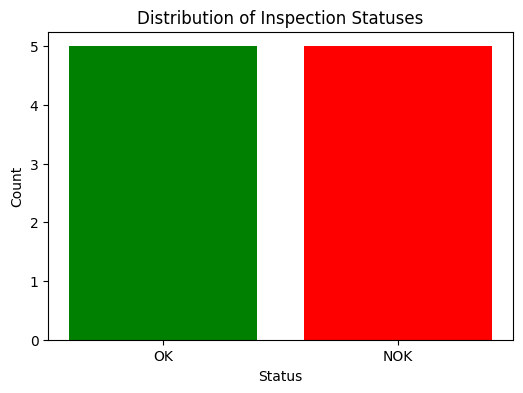

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(status_counts.index, status_counts.values, color=['green', 'red'])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Inspection Statuses')
plt.show()

In [8]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1hxnG6ppeTtKKh6QBvu2NLlHJl5y_EMf2a4_PZJe-ud8/edit#gid=0


# Task
Visualize the distribution of 'OK' and 'NOK' statuses from the DataFrame.

## Count statuses

### Subtask:
Count the occurrences of "OK" and "NOK" in the 'OK/NOK' column of the DataFrame.


**Reasoning**:
Count the occurrences of "OK" and "NOK" in the 'OK/NOK' column and print the result.



In [10]:
status_counts = df['OK/NOK'].value_counts()
print(status_counts)

OK/NOK
OK     5
NOK    5
Name: count, dtype: int64


## Create bar plot

### Subtask:
Generate a bar plot to visualize the counts of "OK" and "NOK" statuses.


**Reasoning**:
Generate a bar plot to visualize the counts of "OK" and "NOK" statuses.



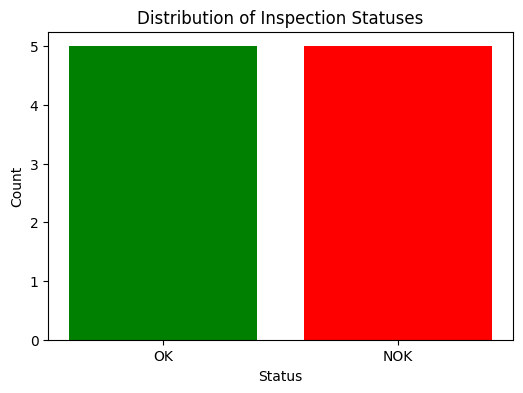

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(status_counts.index, status_counts.values, color=['green', 'red'])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Inspection Statuses')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The analysis counted the occurrences of "OK" and "NOK" statuses, finding 5 occurrences for each.
*   A bar plot was successfully generated to visualize the distribution of these statuses.

### Insights or Next Steps

*   The distribution is evenly split between "OK" and "NOK" statuses.
*   Further analysis could investigate factors contributing to the "NOK" status.
